In [1]:
# Packages required

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from glob import glob
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

# Camera Calibration

To be calibrate camera we'll use photos of chessboards. By using **cv2.findChessboardCorners** we will find out coordinates of chessboard corners in the image. Then we will create mapping for those points in real 3D space using **np.mgrid**. Then by using image point and object point mappings we will calculate camera matrix and distortion co-efficients by using **cv2.calibrateCamera**. Now we can undistort any image captured by the same camera that took calibration images, by using **cv2.undistort**

In [2]:
# Camera Calibration

x, y = 9,6   # Dimention of the chessboards to look into calibration images
image_points = []

for calibration_image in glob('camera_cal/calibration*.jpg'):
    img = mpimg.imread(calibration_image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # calculating coordinates of chessboard corners in the image
    ret, corners = cv2.findChessboardCorners(gray, (x,y), None)
    if ret: image_points.append(corners)

# Preparing corrdinates of chessboard corners in 3D space         
object_points = [np.mgrid[:x,:y,:1].T.reshape(-1,3).astype(np.float32)]*len(image_points)

# calculating camera matrix and distortion co-efficients using cv2.calibrateCamera
ret, camera_matrix, distortion_coeffs, _, _ = cv2.calibrateCamera(object_points, image_points, gray.shape, None, None)

def undistort(img, camera_matrix = camera_matrix, distortion_coeffs = distortion_coeffs):
    '''
    This function takes the distorted image and returns the undistorted version of it by 
    passing, camera matrix and distortion coefficients calculated by images in /camera_cal 
    directory, to the cv2.undistort.
    '''
    return cv2.undistort(img, camera_matrix, distortion_coeffs, None, camera_matrix)

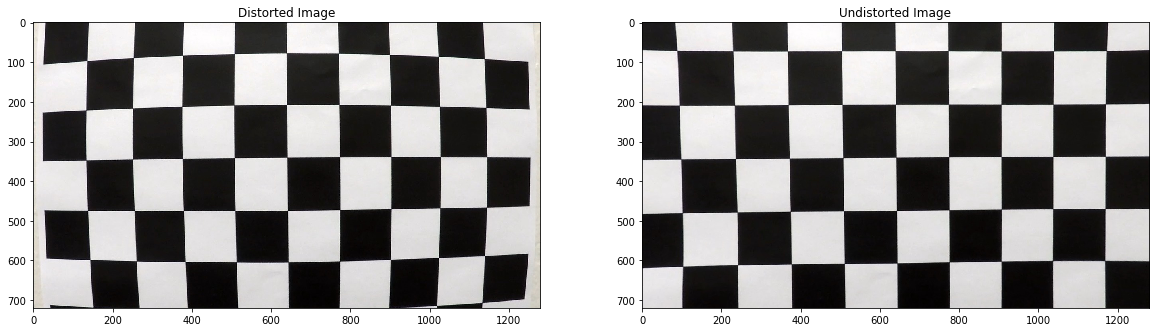

In [3]:
# Undistorting a distorted image

distorted_image = mpimg.imread('camera_cal/calibration1.jpg')
undistorted_image = undistort(distorted_image)


_ = plt.subplots(figsize=(20, 10))

ax1 = plt.subplot(121)
ax1.set_title('Distorted Image')
ax1.imshow(distorted_image)

ax2 = plt.subplot(122)
ax2.set_title('Undistorted Image')
ax2.imshow(undistorted_image)

plt.show()

# Thresholding

In this section we'll use multiple thresholding techniques like Absolute-Sobel thresholding, Magnitude-Sobel thresholding, Directional-Sobel thresholding, Color thresholding in RGB and HLS color spaces.

In [4]:
def abs_sobel_threshold(img, orient='x', thresh_min=0, thresh_max=255, sobel_kernel=3):
    '''
    This function computes absolute sobel threshold of the given image
    '''
    
    # If image is colorful, then convert it into grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
        
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    # Scaling    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Applying Thresholds
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output


def mag_sobel_threshold(img, thresh_min=0, thresh_max=255, sobel_kernel=3):
    '''
    This function computes magnitude sobel threshold of the given image
    '''
    
    # If image is colorful, then convert it into grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img

    # Computing gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Computing gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Scaling
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 

    # Applying Thresholds
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

    return binary_output


def dir_sobel_threshold(img, thresh_min=0, thresh_max=np.pi/2, sobel_kernel=3):
    '''
    This function computes directional sobel threshold of the given image
    '''
    
    # If image is colorful, then convert it into grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    
    # Computing gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Computing gradient direction
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # Applying Thresholds
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh_min) & (absgraddir <= thresh_max)] = 1

    return binary_output


def single_channel_threshold(img, channnel_num, thresh_min=0, thresh_max=255):
    '''
    This function takes a multichannel image and applies thresholds to the provided channel
    '''
    channel = img[:,:,channnel_num]
    output = np.zeros_like(channel)
    output[(channel > thresh_min) & (channel <= thresh_max)] = 1
    
    return output

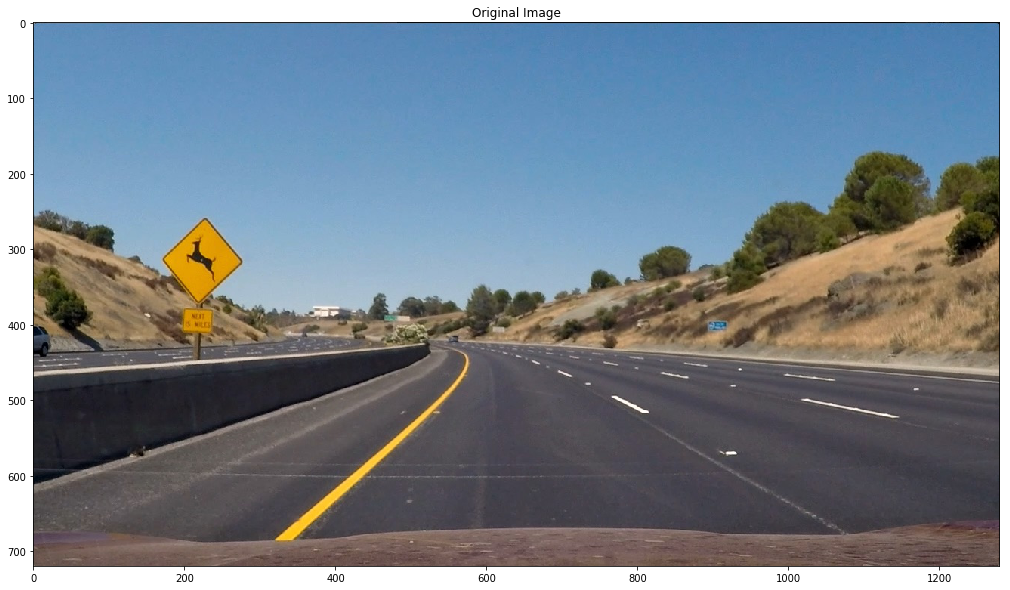

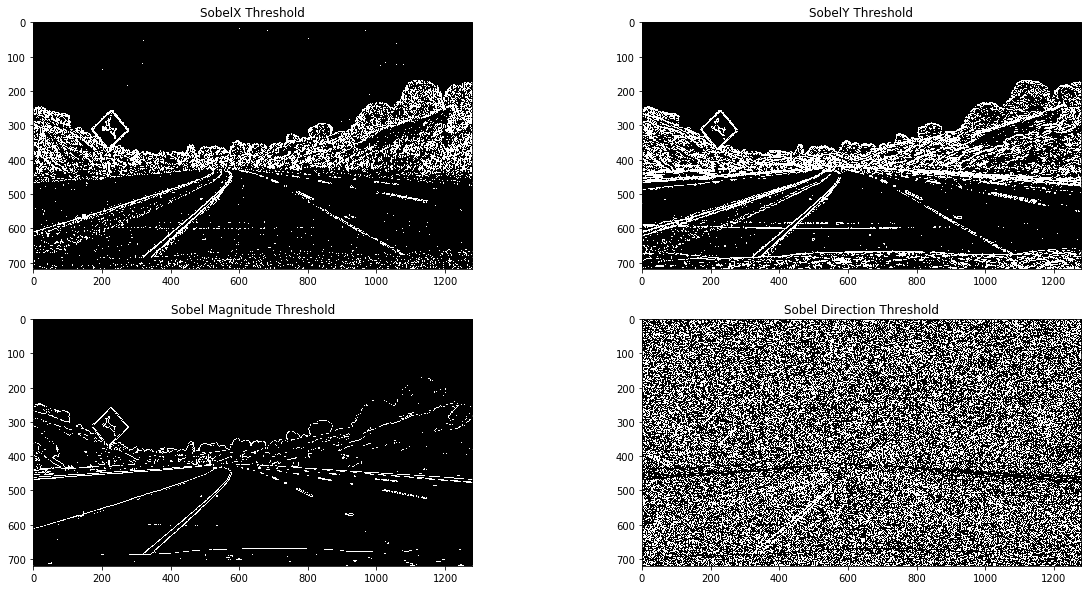

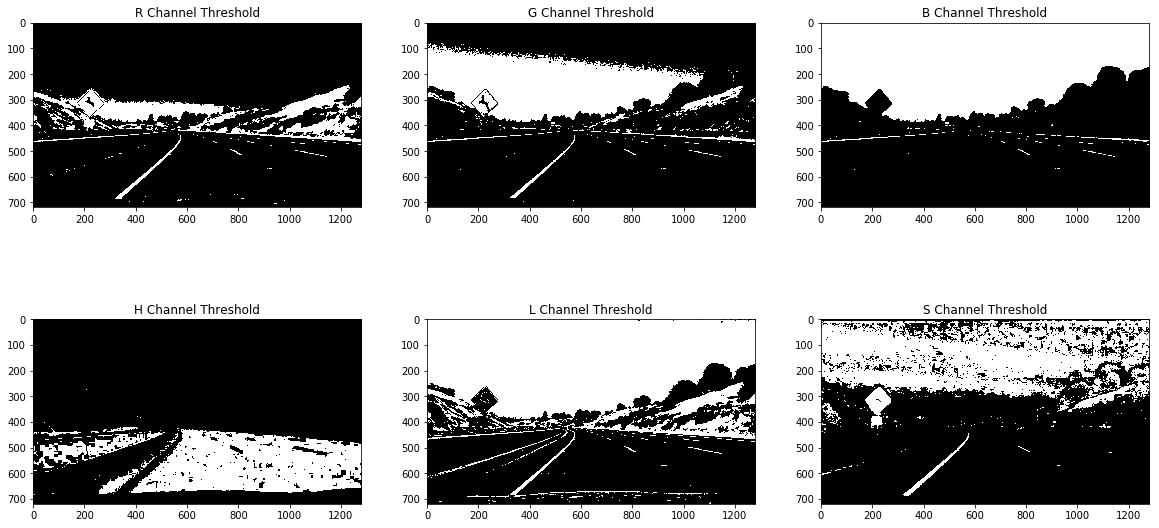

In [5]:
# Applying all the above thresholding techniques to a sample image

image = mpimg.imread('test_images/test2.jpg')

HLS_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

sobelX = abs_sobel_threshold(image, 'x', 10, 200)
sobelY = abs_sobel_threshold(image, 'y', 10, 200)
sobel_mag = mag_sobel_threshold(image, 50, 200)
sobel_dir = dir_sobel_threshold(image, 0.7, 1.3)

R = single_channel_threshold(image, 0, 150, 255)
G = single_channel_threshold(image, 1, 150, 255)
B = single_channel_threshold(image, 2, 150, 255)

H = single_channel_threshold(HLS_image, 0, 120, 150)
L = single_channel_threshold(HLS_image, 1, 120, 255)
S = single_channel_threshold(HLS_image, 2, 100, 255)


_ = plt.subplots(figsize=(20, 10))

plt.title('Original Image')
plt.imshow(image)
plt.show()

_ = plt.subplots(figsize=(20, 10))

ax1 = plt.subplot(221)
ax1.set_title('SobelX Threshold')
ax1.imshow(sobelX, cmap='gray')

ax2 = plt.subplot(222)
ax2.set_title('SobelY Threshold')
ax2.imshow(sobelY, cmap='gray')

ax3 = plt.subplot(223)
ax3.set_title('Sobel Magnitude Threshold')
ax3.imshow(sobel_mag, cmap='gray')

ax4 = plt.subplot(224)
ax4.set_title('Sobel Direction Threshold')
ax4.imshow(sobel_dir, cmap='gray')

plt.show()

_ = plt.subplots(figsize=(20, 10))

ax1 = plt.subplot(231)
ax1.set_title('R Channel Threshold')
ax1.imshow(R, cmap='gray')

ax2 = plt.subplot(232)
ax2.set_title('G Channel Threshold')
ax2.imshow(G, cmap='gray')

ax3 = plt.subplot(233)
ax3.set_title('B Channel Threshold')
ax3.imshow(B, cmap='gray')

ax4 = plt.subplot(234)
ax4.set_title('H Channel Threshold')
ax4.imshow(H, cmap='gray')

ax5 = plt.subplot(235)
ax5.set_title('L Channel Threshold')
ax5.imshow(L, cmap='gray')

ax6 = plt.subplot(236)
ax6.set_title('S Channel Threshold')
ax6.imshow(S, cmap='gray')

plt.show()

## Combining Thresholds

In this section, we will combine multiple thresholding techniques in a way that it will be able to identify both yellow and white road lane lines efficiently in an image. We will take advantages to the facts that, R & G channels in RGB color space, S channel in HLS space along with SobelX can determine road lane lines efficiently.

In [6]:
def combined_threshold(img):
    '''
    This function applies threshold to an image in order to identify road lane lines efficiently
    '''
    
    # converting image to grayscale and HLS
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    HLS_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Calculating thresholds by all techniques
    sobelX = abs_sobel_threshold(gray, 'x', 10, 200)
    sobelY = abs_sobel_threshold(gray, 'y', 10, 200)
    sobel_mag = mag_sobel_threshold(gray, 10, 200)
    sobel_dir = dir_sobel_threshold(gray, 0.7, 1.3)

    R = single_channel_threshold(img, 0, 150, 255)
    G = single_channel_threshold(img, 1, 150, 255)
    B = single_channel_threshold(image, 2, 150, 255)

    H = single_channel_threshold(HLS_image, 0, 100, 255)
    L = single_channel_threshold(HLS_image, 1, 100, 255)
    S = single_channel_threshold(HLS_image, 2, 100, 255) 
    
    # For Sobel Threhold we will consider absolute sobel in X direction as whenever road lanes lines
    # appear in an image, its gradient in x direction abruptly changes. So we will combine sobelX and sobel_dir
    sobel_threshold = (sobelX == 1) & (sobel_dir == 1)
    
    # For color threshold we will choose channel R and G as they detect yellow lanes. We will consider R and G
    # channels only when there is ample lightness
    color_threshold = (R == 1) & (G == 1) & (L == 1)
    
    # S channel appears to detect both yellow and white lanes with highest efficiency even in varying lighting conditions
    hls_threshold   = (S == 1) 
    
    output = np.zeros_like(H)
    
    # for the final combination of thresholds, either saturation or gradients must be present along with R and G channels
    output[color_threshold & (hls_threshold | sobel_threshold)] = 1
    
    return output


def get_roi_vertices(X=1280, Y=720, top_left_offset=550, top_right_offset=550, bottom_left_offset=120, bottom_right_offset=120):
    '''
    This function computes vertices of the area of interest on the basis of provided offset.
    NOTE: it only focuses on bottom 40% of the image
    '''
    return np.array([[(bottom_left_offset,Y),
                      (top_left_offset, 0.6*Y),
                      (X-top_right_offset, 0.6*Y), 
                      (X-bottom_right_offset, Y)]], dtype=np.int32)


def region_of_interest(img, vertices = get_roi_vertices()):
    '''
    This function returns area of interest in an image based on provided vertices
    '''
    
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        color = (255,) * channel_count
    else:
        color = 255
        
    cv2.fillPoly(mask, vertices, color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

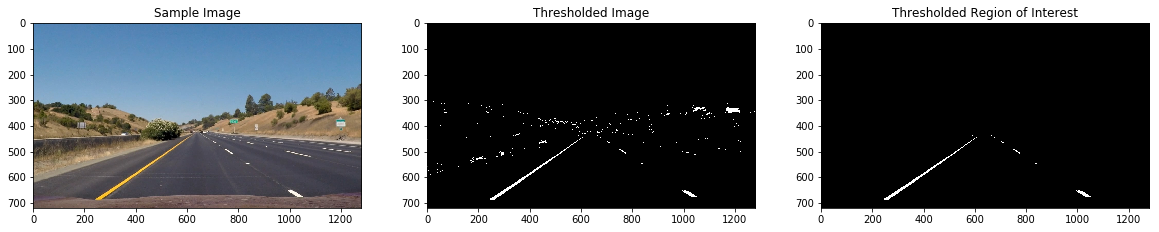

In [7]:
# Applying combined threshold and getting area of interest for a sample image

img = mpimg.imread('test_images/straight_lines1.jpg')
thresh = combined_threshold(img)
thresh_roi = region_of_interest(thresh)

_ = plt.subplots(figsize=(20, 10))

ax1 = plt.subplot(131)
ax1.set_title('Sample Image')
ax1.imshow(img)

ax2 = plt.subplot(132)
ax2.set_title('Thresholded Image')
ax2.imshow(thresh, cmap='gray')

ax3 = plt.subplot(133)
ax3.set_title('Thresholded Region of Interest')
ax3.imshow(thresh_roi, cmap='gray')

plt.show()

# Perspective Transform

In this section, we will compute top view (Birs's eye view) of the lane so that we can calculate radius of curvature of the lanes, which will eventually help us in finding steering angle and other useful information. 
To get this perspective transform, first, we will take a sample image which has straight road lanes and we will manually choose 4 points in the image whose transformed coordinates we can calculate. Then, we will use **cv2.getPerspectiveTransform** to get  transform matrix and inverse transform matrix. Finally, we can warp and unwarp the perspective by using transform matrix and inverse transform matrix along with **cv2.warpPerspective**

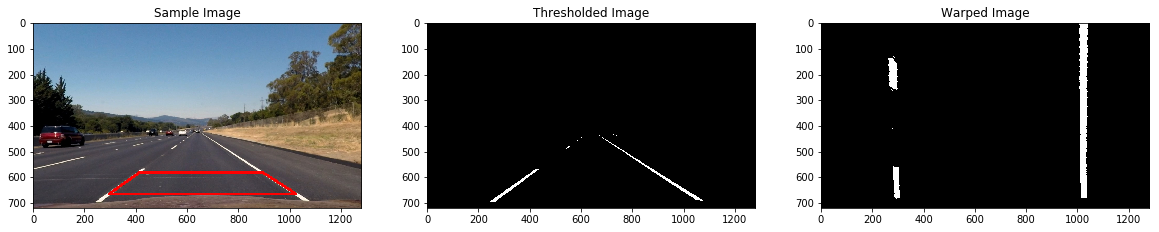

In [8]:
img = mpimg.imread('test_images/straight_lines2.jpg') # sample image with straight road lanes
undistorted_img = undistort(img)
thresholded_img = region_of_interest(combined_threshold(undistorted_img))

# Manually chosen points on source
src = np.array([[295,665],[415,580],[892,580],[1024,665]], np.float32)

# Manually calculted points for the destination
dst = np.array([[295,665],[295,580],[1024,580],[1024,665]], np.float32)

# Plotting polygon around the chosen points
cv2.polylines(undistorted_img, np.array([src], np.int32), True, (255,0,0), 10)

# Calculating transformation matrix and inverse transformation matrix
M = cv2.getPerspectiveTransform(src, dst)
M_ = cv2.getPerspectiveTransform(dst, src)

# Warping perspective using transformation matrix with cv2.warpPerspective
warped_img = cv2.warpPerspective(thresholded_img, M, thresholded_img.shape[::-1] , flags=cv2.INTER_LINEAR)

_ = plt.subplots(figsize=(20, 10))

ax1 = plt.subplot(131)
ax1.set_title('Sample Image')
ax1.imshow(undistorted_img)

ax2 = plt.subplot(132)
ax2.set_title('Thresholded Image')
ax2.imshow(thresholded_img, cmap='gray')

ax3 = plt.subplot(133)
ax3.set_title('Warped Image')
ax3.imshow(warped_img, cmap='gray')

In [9]:
def warped(thresholded_image):
    '''
    This function warps prespective of an image from front view to bird's eye view by using transformation matrix calculated
    earlier
    '''
    return cv2.warpPerspective(thresholded_image, M, thresholded_image.shape[::-1] , flags=cv2.INTER_NEAREST)

def unwarped(color_warp):
    '''
    This function warps prespective of an image from  bird's eye to front view view by using inverse transformation matrix 
    calculated earlier.
    NOTE: This function takes colorful warped images as argument
    '''
    return cv2.warpPerspective(color_warp, M_, color_warp.shape[::-1][1:])

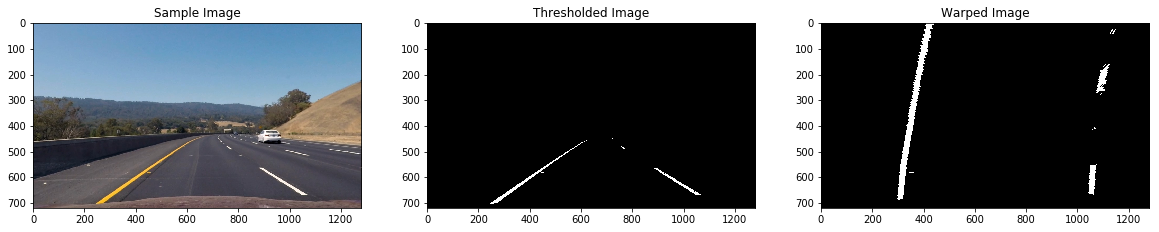

In [10]:
# Warping a sample image

img = mpimg.imread('test_images/test3.jpg')
undistorted_img = undistort(img)
thresholded_img = region_of_interest(combined_threshold(undistorted_img))
warped_img = warped(thresholded_img)

_ = plt.subplots(figsize=(20, 10))

ax1 = plt.subplot(131)
ax1.set_title('Sample Image')
ax1.imshow(undistorted_img)

ax2 = plt.subplot(132)
ax2.set_title('Thresholded Image')
ax2.imshow(thresholded_img, cmap='gray')

ax3 = plt.subplot(133)
ax3.set_title('Warped Image')
ax3.imshow(warped_img, cmap='gray')

plt.show()

# Lane Detection

In this section we will find out pixels corresponding to the lane lines in a binary warped image. To find lane pixels we will first plot histogram histogram along all the columns in the lower half of the image. With this histogram we are adding up the pixel values along each column in the image. In our thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. We can use that as a starting point for where to search for the lines. From that point, we can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

In [11]:
def find_lane_pixels(binary_warped):
    
    # Calculating histogram along all coulumns in lower half of the binary warped image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Calculating possible x coordinates to start finding lane lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Hyperparameters
    nwindows = 9
    margin = 100
    minpix = 50

    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Finding activated indices
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    # performing sliding window
    for window in range(nwindows):
        
        # Calculating corner points for the left and right windows
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Drawing left and right window
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Filtering out activated indices
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    # Calculating activated points
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, histogram


def fit_polynomial(binary_warped):
    '''
    This function fits 2 degree polynomial to road lanes detected in the given binary warped image
    '''
    
    # Calulates activated right an left lane pixels
    leftx, lefty, rightx, righty, out_img, histogram = find_lane_pixels(binary_warped)

    # Fitting the curve
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Plotting the curve
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    out_img[ploty.astype(np.int), left_fitx.astype(np.int)]   = [255, 255, 0]
    out_img[ploty.astype(np.int), right_fitx.astype(np.int)]  = [255, 255, 0]    

    return left_fit, right_fit, histogram, out_img, (leftx,lefty,rightx,righty)

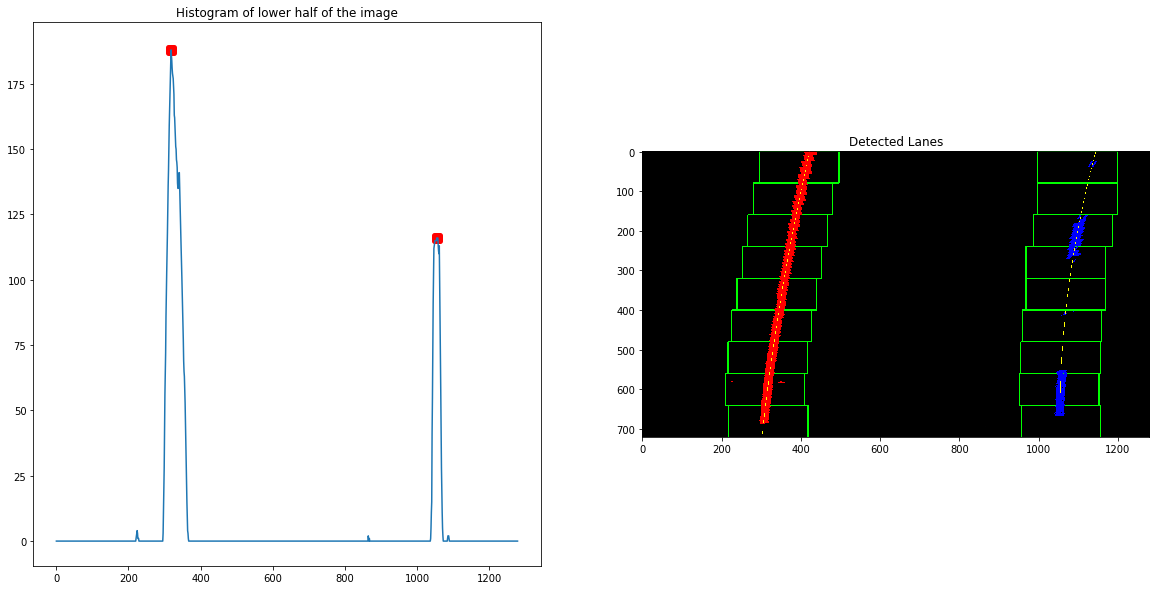

In [12]:
# Plotting Histogram and detecting lane for a previously calculated sample warped image

left_fit, right_fit, histogram, out_img,_ = fit_polynomial(warped_img)

midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

plt.show()

_ = plt.subplots(figsize=(20, 10))

ax1 = plt.subplot(1,2,1)
ax1.set_title('Histogram of lower half of the image')
ax1.plot(histogram)
ax1.scatter(x=[leftx_base,rightx_base], y =[histogram[leftx_base],histogram[rightx_base]], marker='s', c='red', linewidth=5)

ax2 = plt.subplot(1,2,2)
ax2.set_title('Detected Lanes')
ax2.imshow(out_img)

plt.show()

In [29]:
# Saving Intermediate steps for test images

test_images = glob('test_images/*jpg')

for i in range(len(test_images)):
    
    im_path = test_images[i]
    img = plt.imread(im_path)
    undistorted_img = undistort(img)
    thresholded_img = region_of_interest(combined_threshold(undistorted_img))
    warped_img = warped(thresholded_img)
    _,_,_,lane,_ = fit_polynomial(warped_img)
    
    plt.imsave(im_path.replace('test_images','output_images\\undistorted'), undistorted_img)
    plt.imsave(im_path.replace('test_images','output_images\\thresholded'), thresholded_img, cmap='gray')
    plt.imsave(im_path.replace('test_images','output_images\\warped'), warped_img, cmap='gray')
    plt.imsave(im_path.replace('test_images','output_images\\detected_lane'), lane, cmap='gray')

# Search around previous detected lines

In [13]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    '''
    This function fits a 2 degree polynomial to left and right activated pixels of a binary warped image
    '''
    
    # Fitting curve
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Calculating plotting points
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_fit_prev, right_fit_prev):
    '''
    This function takes a binary warped image of road lanes and fits 2 degree polynomial to the left lane and right
    lane on the basis of detected lanes and previously detected lanes
    '''

    margin = 100

    # Calculating activated indices
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Calculating lane indices
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
                    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
                    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
                    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
                    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))
    
    # calculating activated lane points
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fitting the curve
    left_fitx, right_fitx, ploty, lfit, rfit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # plotting lane pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    result[ploty.astype(np.int), left_fitx.astype(np.int)]   = [255, 255, 0]
    result[ploty.astype(np.int), right_fitx.astype(np.int)]  = [255, 255, 0]

    return lfit, rfit, result, (leftx,lefty,rightx,righty)

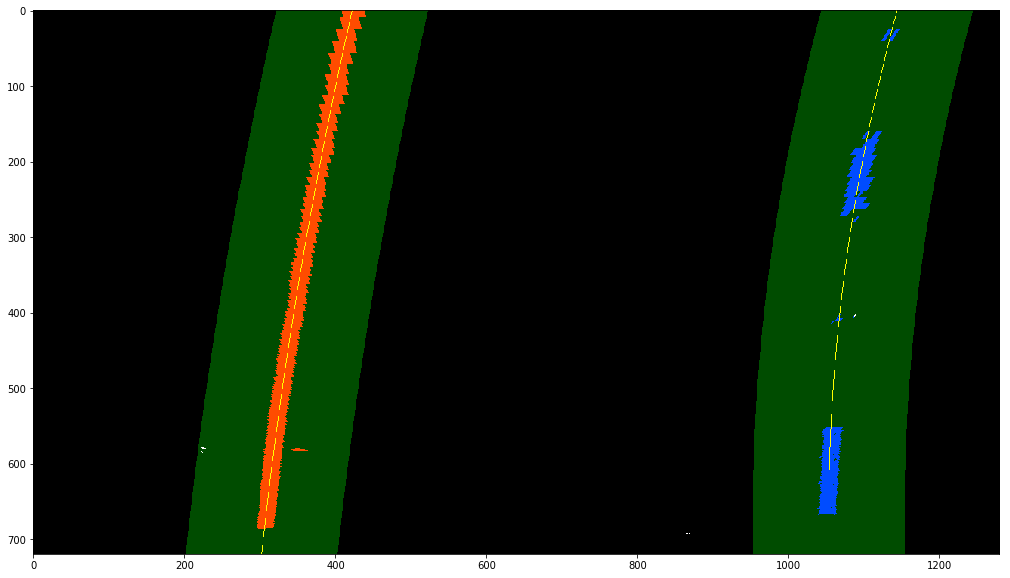

In [14]:
# Fitting curve on a sample binary warped image basis of given previously detected lines

left_fit_prev  = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit_prev = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

_, _, result, coordinates = search_around_poly(warped_img, left_fit_prev, right_fit_prev)

_ = plt.subplots(figsize=(20, 10))
plt.imshow(result)
plt.show()

# Measuring radius of curvature and center offset

In [15]:
def measure_curvature_real(img_shape, left_fit_cr, right_fit_cr, xm_per_pix = 3.7/700, ym_per_pix = 30/720):
    '''
    This function calculates radius of curvature of left ang right road lanes in a binary warped image
    given curve equation of both the lanes
    '''
    y_eval = img_shape[0]-1 # point in image where it will calculate radius of curvature
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

def measure_center_offset_real(img_shape, left_fit_cr, right_fit_cr, xm_per_pix = 3.7/700):
    '''
    This function calculates offset from the center of the road lanes in a binary warped image
    given curve equation of both the lanes
    '''    
    y_eval = img_shape[0]-1 # point in image where it will calculate center offset
    
    lane_left_x = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
    lane_right_x = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]
    lane_center_x = (lane_left_x + lane_right_x)//2
    
    image_center_x = img_shape[1]//2
    
    return (image_center_x - lane_center_x)*xm_per_pix

In [16]:
# Calculating radius of curvature and center offset for previosly calculated sample binary warped image

left_fit, right_fit, histogram, out_img,_ = fit_polynomial(warped_img)
left_curverad, right_curverad = measure_curvature_real(out_img.shape, left_fit, right_fit)
offset = measure_center_offset_real(out_img.shape, left_fit, right_fit)

print('Left line curvature:', left_curverad, 'm')
print('Right line curvature:', right_curverad, 'm')
print('Center offset:', offset, 'm')

Left line curvature: 6573.70446861 m
Right line curvature: 2763.64836654 m
Center offset: -0.195571428571 m


# Drawing Lanes and Metrics

In [17]:
def draw_lane(img, warped_img, left_fit, right_fit, coordinates):
    '''
    This function draws lane on `img` using `warped_img`, `left_fit` and, `right_fit`
    '''
    # defining empty colored image
    warp = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp, warp, warp))

    # Calculating lane pixels
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
    pts_left_x = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    pts_right_x = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    pts_left = np.vstack([pts_left_x.astype(np.int),ploty.astype(np.int)]).transpose()
    pts_right = np.vstack([pts_right_x.astype(np.int),ploty.astype(np.int)]).transpose()
    pts = np.vstack([pts_left,np.flipud(pts_right)])

    # plotting green polygon on lane
    cv2.fillPoly(color_warp, [pts], (0,255, 0))
    
    # plotting lane pixels
    for center in zip(coordinates[0],coordinates[1]):
        cv2.circle(color_warp,center, 5, (255,0,0), 5)
    for center in zip(coordinates[2],coordinates[3]):
        cv2.circle(color_warp,center, 5, (0,0,255), 5)
    
    # unwarping image
    unwarped_img = unwarped(color_warp)
    
    # merging detected lane image with actual image
    weighted_img = cv2.addWeighted(img, 1, unwarped_img, 0.3, 0)
    
    return weighted_img 

def draw_metrics(img, left_fit, right_fit, xm_per_pix = 3.7/700, ym_per_pix = 30/720):
    '''
    This function draws radius of curvature and offset on `img`
    '''
    left_curverad, right_curverad = measure_curvature_real(img.shape, left_fit, right_fit, xm_per_pix, ym_per_pix)
    offset = measure_center_offset_real(img.shape, left_fit, right_fit, xm_per_pix)
    
    curverad = 'Radius of Curvature =  %d(m)'%min(left_curverad,right_curverad)
    if offset < 0:
        offset = 'Vehicle is %.2fm left of center'%abs(offset)
    else:
        offset = 'Vehicle is %.2fm right of center'%offset
        
    cv2.putText(img,curverad,(50,80), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),3,cv2.LINE_AA)
    cv2.putText(img,offset,(50,160), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),3,cv2.LINE_AA)
    
    return img

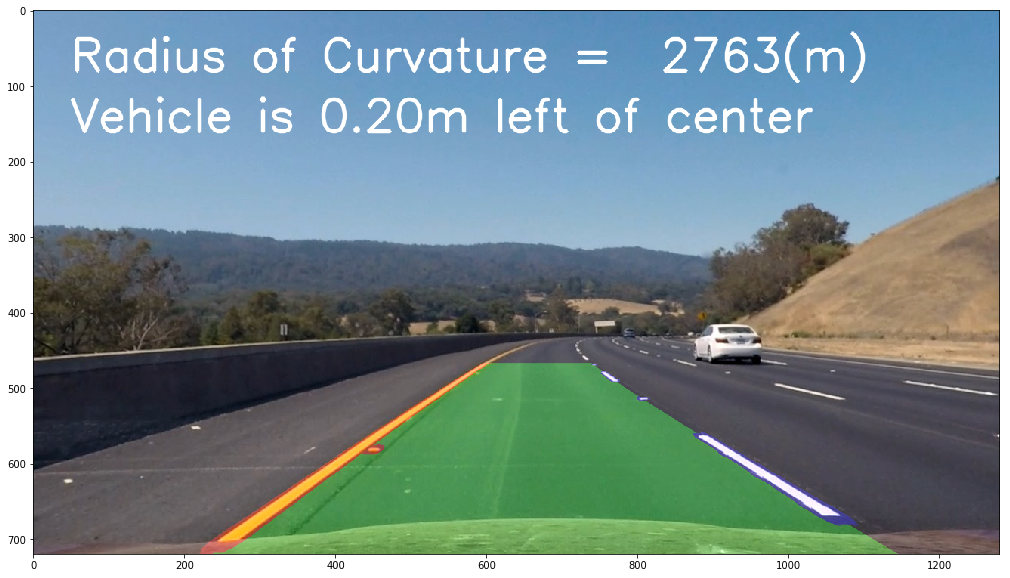

In [18]:
# Drawing lanes and metrics on a sample image

img_lane = draw_lane(undistorted_img, warped_img, left_fit, right_fit, coordinates)
img_lane_metric = draw_metrics(img_lane, left_fit, right_fit)

_ = plt.subplots(figsize=(20, 10))
plt.imshow(img_lane_metric)
plt.show()

# Pipeline

In this section we will combine all the above impelemented functions in order to generate end to end pipeline 
to get annotated image with detected lanes

In [19]:
deque_maxlen = 10  # smoothen over this many frames  
prev_detected_lines = deque(maxlen=deque_maxlen) # GLOBAL variable used in smoothen_lines

def smoothen_lines(left_line, right_line):
    '''
    This function smoothens the detected lines using `prev_detected_lines`
    '''
    global prev_detected_lines
    
    if (left_line is None) or (right_line is None):
        if prev_detected_lines:
            # If pipeline fails to detec line, returns previous detected line
            return prev_detected_lines[-1][0], prev_detected_lines[-1][1]
        return None, None
    
    if len(prev_detected_lines) < deque_maxlen:
        # if previously detected line buffer isn't full add current detected line in the buffer
        prev_detected_lines.append((left_line, right_line))
        return left_line, right_line
    
    # If line buffer is full returns the averaged line
    prev_detected_lines.append((left_line, right_line))
    left_smoothened, right_smoothened = [sum(i)/deque_maxlen for i in zip(*prev_detected_lines)]
    return left_smoothened, right_smoothened



left_fit_prev, right_fit_prev = None, None # GLOBAL variables used in pipeline

def pipeline(img, smoothening=True, search_around_previous_detections = True):
    '''
    This function is end to end pipeline to get annotated image of detected lanes
    '''
    global left_fit_prev, right_fit_prev

    try:
        # Step 1: Undistort the image
        undistorted_image = undistort(img)
        
        # Step 2: Threshold the image
        thresholded_image = combined_threshold(undistorted_image)
        
        # Step 3: Get area of interest
        thresholded_image_roi = region_of_interest(thresholded_image)
        
        # Step 4: Compute bird's eye view 
        warped_image = warped(thresholded_image_roi)
        
        # Step 5: Detect lane Lines
        if search_around_previous_detections:
            try:
                # Search around previously detected lines
                left_fit, right_fit, _, coordinates = search_around_poly(warped_image, left_fit_prev, right_fit_prev)
                left_fit_prev, right_fit_prev = left_fit, right_fit
            except:
                try:
                    # Search from scratch by histogram method
                    left_fit, right_fit, _, _, coordinates = fit_polynomial(warped_image)
                    left_fit_prev, right_fit_prev = left_fit, right_fit
                except:
                    left_fit, right_fit = None, None

            if smoothening:
                # Smoothen over past frames
                left_fit, right_fit = smoothen_lines(left_fit, right_fit)
        else:
            # Search from scratch by histogram method
            left_fit, right_fit, _, _, coordinates = fit_polynomial(warped_image)
        
        # Step 6: Draw lanes
        img_lane = draw_lane(undistorted_image, warped_image, left_fit, right_fit, coordinates)
        
        # Step 7: Draw metrics
        out_img = draw_metrics(img_lane, left_fit, right_fit)
        return out_img
    except:
        return img

# Running Pipeline

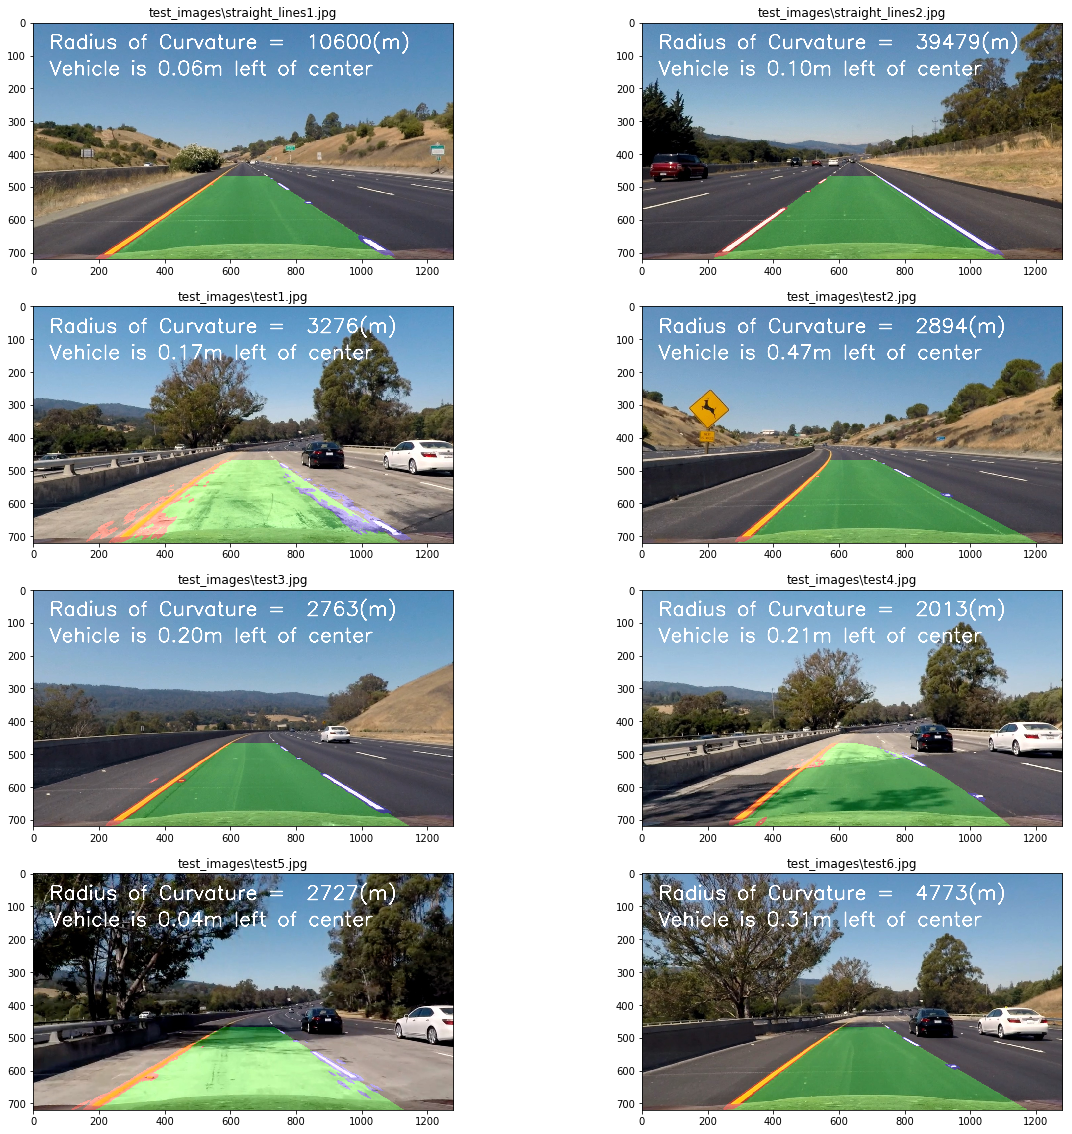

In [27]:
# Run end to end pipeline on test images

test_images = glob('test_images/*jpg')

_ = plt.subplots(figsize=(20, 20))

for i in range(len(test_images)):
    
    im_path = test_images[i]
    img = plt.imread(im_path)
    out = pipeline(img, False, False)
    
    plt.imsave(im_path.replace('test_images','output_images\\final'), out)
    
    ax = plt.subplot(4,2,i+1)
    ax.set_title(im_path)
    ax.imshow(out)
    
plt.show()

### Annotating Project Video

In [21]:
output = 'project_video_output.mp4'
clip = VideoFileClip('project_video.mp4')

prev_detected_lines = deque(maxlen=deque_maxlen)
left_fit_prev, right_fit_prev = None, None

clip = clip.fl_image(pipeline)
clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [12:17<00:00,  1.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



### Annotating Challenge Video

In [22]:
output = 'challenge_video_output.mp4'
clip = VideoFileClip('challenge_video.mp4')

prev_detected_lines = deque(maxlen=deque_maxlen)
left_fit_prev, right_fit_prev = None, None

clip = clip.fl_image(pipeline)
clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [03:44<00:00,  2.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 



### Annotating Harder Challenge Video

In [23]:
output = 'harder_challenge_video_output.mp4'
clip = VideoFileClip('harder_challenge_video.mp4')

prev_detected_lines = deque(maxlen=deque_maxlen)
left_fit_prev, right_fit_prev = None, None

clip = clip.fl_image(pipeline)
clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [18:51<00:00,  1.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

